In [97]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

import re
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
import string
from gensim.models import Word2Vec  
import html
from bs4 import BeautifulSoup
from collections import Counter

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's import the data and see what it looks like.

In [98]:
data = pd.read_csv("IMDBDataset.csv")
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Now we see that data has 2 columns a review column with the reviews and the sentiment column with either positve for a good review or negative for a bed review.

Let's see how sentiment is distributed. And it is exactly even as you can see below!

In [99]:
sentiment_counts = data["sentiment"].value_counts()
sentiment_counts

positive    25000
negative    25000
Name: sentiment, dtype: int64

Let's plot the top 30 most frequent words to see what the text is made up of.

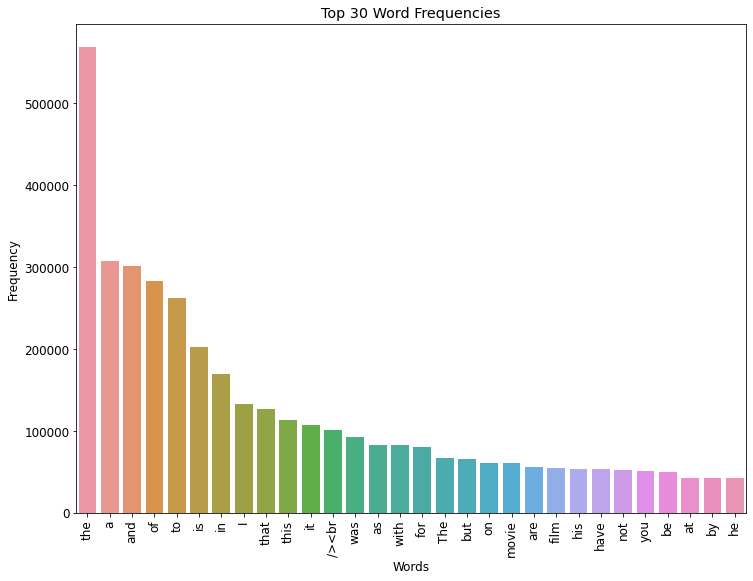

In [100]:
word_freq = {}
for sentence in data["review"]:
    words = sentence.split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else: word_freq[word] += 1

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Plot the word frequencies using seaborn
sns.barplot(x=df_word_freq.index[:30], y=df_word_freq['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

As you can see above most of these words in the top 30 are stopwords which don't carry much meaning of the underlying review so these will be filtered out in the preprocessing later. Also there are still a lot of html embedding in the text which also need to be filtered out among other things.

Let's clean the data.

In [101]:
def clean_text(text):
    if type(text) != str or text=='':
        return ''

    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r"(?<=\b\w) n't", " not", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("(?<=[0-9])\,(?=[0-9])", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub("whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("&", "and", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub(r'i\'m', 'i am', text)
    text = re.sub(r"\b\d+(\.\d+)?\b", "", text)
    text = re.sub(r"\.{2,}", "", text)
    text = re.sub(r"(?<=\b\w)(-+)(?=\b\w)", " ", text)
    text = re.sub(r"[+*=\",_/$\-:]", "", text)
    #remove stopwords and apply lemmatization instead of stemming because it is more accurate
    stopwords_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [word for word in text if word.lower() not in stopwords_set]
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return " ".join(text)

Let's compare the reviews before and after preprocessing to see what has changed.

In [102]:
a = 0
for i in range(a, a + 10):
    print(data.review[i])
    print()

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [103]:
data["review"] = data["review"].apply(clean_text)
a = 0
for i in range(a, a + 10):
    print(data.review[i])
    print()


one reviewer mentioned watching oz episode hooked. right exactly happened me. first thing struck oz brutality unflinching scene violence set right word go. trust show faint hearted timid. show pull punch regard drug sex violence. hardcore classic use word. called oz nickname given oswald maximum security state penitentary. focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda. em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far away. would say main appeal show due fact go show dare. forget pretty picture painted mainstream audience forget charm forget romanceoz mess around. first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence. violence injustice watching oz may become comfortable uncomfortable viewingthats get touch darker side.

wonderful little production. filming technique unassum

<a name='1'></a>
## TODO
EXPLAIN CHANGES

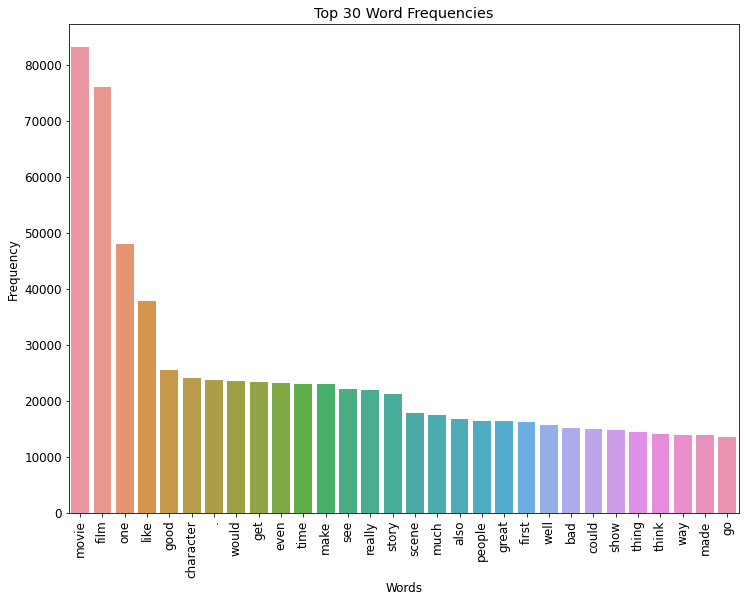

In [104]:
word_freq = {}
for sentence in data["review"]:
    words = sentence.split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else: word_freq[word] += 1

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Plot the word frequencies using seaborn
sns.barplot(x=df_word_freq.index[:30], y=df_word_freq['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

As seen above in the plot, now that the stopwords are filtered the words which might give clues about the sentiment of the review are much more pronounced such as the words bad, good, like.

Let's see if there are some duplicate sentences in the data.


In [105]:
sent_freq = {}
for sentence in data["review"]:
    if sentence not in sent_freq:
       sent_freq[sentence] = 1
    else: sent_freq[sentence] += 1

df_sent_freq = pd.DataFrame.from_dict(sent_freq, orient='index', columns=['Frequency'])
df_sent_freq = df_sent_freq.sort_values(by='Frequency', ascending=False)

df_sent_freq.head()

,Frequency
loved today show!!! variety solely cooking . stimulating captivating always keeping viewer peeking around corner see coming next. earth personable get like one u made show enjoyable. special guest friend well made nice surprise too. loved 'first' theme audience invited play along too. must admit shocked see come time limit thing golly writing recipe down. saving time kitchen mean time family. tuned yet find channel time assure disappointed.,5
hilarious clean lighthearted quoteworthy. else ask film? alltime number one favorite movie. ever since little girl dreamed owning blue van flame observation bubble. cliché character ridiculous situation make film great fun. wonderful comedic chemistry stephen furst andy tennant make favorite part movie. love hopeless awkwardness flynch? forget airport antic leon crony dressed hari krishna dancing chanting playing tambourineunbeatable! clue genius location classic plot timeless. word wise watch film little probably win place heart today. nevertheless give chance may find matter say matter gotta play.,4
got movie free job along three similar movie watched low expectations. movie bad per se. get pay for. tale love betrayal lie sex scandal everything want movie. definitely hollywood blockbuster cheap thrill bad. would probably never watch movie again. nutshell kind movie would see either late night local television station wanting take time would see sunday afternoon local television station trying take time. despite bad acting cliché line sub par camera work. desire turn movie pretend like never popped dvd player. story done many time many movies. one different better worse. average movie.,3
robert jordan television star. robert jordan like thing orderly time properly executed. world child seen heard. would mr. jordan want become master rambunctious band boy scouts? ratings. staff figure learns interact youth inclined watch show. course watching jordan cope comprises fun. like mr. belvedere mr. belvedere go college one sure please. anyone interested obtaining copy film please write iamaseal2@yahoo.com,3
see c. thomas howell appeared many movie since heyday 80 accomplished young actor. bought dvd cheap part internetrelated plot see much older c. thomas howell is; recall seeing movie since 1980s. word big disappointment. give low budget movie chance one started lame. within first minute movie elusive woman chatting asian guy chatroom. basically stimulate chat insists meeting participant person. meet sex tie murder cold blood. plot deteriorates further. plot thin flimsy acting stiff. bother renting much le purchasing even dvd bin. plan take copy dvd goodwill. truly amazed prior reviewer gave movie bad rating.,3


Well there are some duplicate reviews, these are probably bot reviews or just copypastas by the same user so these will get deleted aswell. Deleting these might benefit the model in some ways for exampe inm, data quality since duplicate reviews can artificially inflate the frequency of certain sentiments, skewing the analysis results.
Also it might reduce bias since these duplicate reviews are probably from the same user or bot, their opinions may be overrepresented leading to biased sentiment analysis results.

In [106]:
data.drop_duplicates(subset='review', inplace=True)
data.reset_index(drop=True, inplace=True)
data


,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production. filming technique...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy think zombie close...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49570,thought movie right good job. creative origina...,positive
49571,bad plot bad dialogue bad acting idiotic direc...,negative
49572,catholic taught parochial elementary school nu...,negative
49573,going disagree previous comment side maltin on...,negative


As a quick check lets see the distribution now for the sentiments.

In [107]:
data.sentiment.value_counts()

positive    24880
negative    24695
Name: sentiment, dtype: int64

Not exactly 50/50 anymore because of the removed duplicates but still very close to a 50/50 split.

Now let's transform the sentiments of the reviews from string labels to int numbers. ie 0 = negative and 1 = positive. I do this because changing them to integers allows for easier computations and compatibility with machine learning algorithms and libraries for the classification task.

In [108]:
data["sentiment"] = data["sentiment"].map({"positive": 1, "negative" : 0}).astype(int)
data["sentiment"]

0        1
1        1
2        1
3        0
4        1
        ..
49570    1
49571    0
49572    0
49573    0
49574    0
Name: sentiment, Length: 49575, dtype: int32

Now let's explore bigramcounts for the reviews and see if there is already some hints to be seen about a users sentiment.

In [109]:
bigram_counts = {}
for sentence in data["review"]:
    words = sentence.split()
    for word in range(0, len(words) - 1):
        bigram = words[word] + " " + words[word + 1]
        if bigram not in bigram_counts:
            bigram_counts[bigram] = 1
        else: bigram_counts[bigram] += 1

df_bigram_counts = pd.DataFrame.from_dict(bigram_counts, orient='index', columns=['Frequency'])
df_bigram_counts = df_bigram_counts.sort_values(by='Frequency', ascending=False)

df_bigram_counts.head()

,Frequency
look like,2666
special effect,1886
even though,1778
one best,1737
movie ever,1697


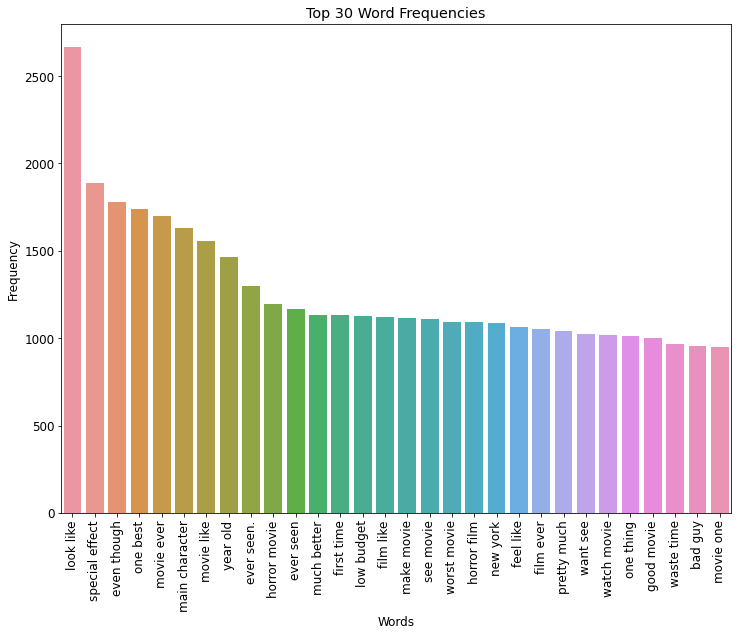

In [110]:
# Plot the word frequencies using seaborn
sns.barplot(x=df_bigram_counts.index[:30], y=df_bigram_counts['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

Above this is now the plot of the bigrams with their counts and we already can see some reviews give some clear clues about the writers sentiment such as the bigrams worst movie and good movie. But now also see that "ever seen." gets treated different to "ever seen" because it doens't have the dot which means end of sentence but I won't remove "." since the bigram might have a different context depending on if it happens mid sentence or at the end of a sentence, since ever seen mid sentence might carry meaning to something before or after this bigram while ever seen. is the end of a sentence.

Let's see if the most counted bigram is spammed or happens loosely in a lot of sentences by printing them.

In [111]:
mask = data["review"].str.contains("look like", case = False)

reviews = data.review[mask]
for sentence in reviews:
    print(sentence)
    print()

success die hard sequel surprise really 1990s glut 'die hard ' movie cashed wrong guy wrong place wrong time concept. cliffhanger die hard mountain time rescue sly top mom shoot' stallone career. cliffhanger one big nitpicker dream especially expert mountain climbing basejumping aviation facial expression acting skills. full excuse dismiss film one overblown pile junk. stallone even managed get outacted horse! however forget nonsense actually lovable undeniably entertaining romp delivers plenty thrill unintentionally plenty laughs. got love john lithgows sneery evilness tick every box band baddie best permanently harassed hapless 'turncoat' agent rex linn travers. may henry 'portrait serial killer' michael rooker noteworthy cringeworthy performance hal insists constantly shrieking painful disbelief captor 'that man never hurt anybody' whilst surely can't really look like ralph waite frank character grinning girl plummet death. mention must go former 'london burning' actor craig fairbra

And it seems like the bigram look like is just used in a lot of sentences and not being spammed thats good since they don't have to be filtered out.

We also added a extra test set of other imdb movie reviews to see if the models also generalise. This extra test set is also from kaggle: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis. Let's quickly go through the dataset and clean it.

In [112]:
dftest = pd.read_csv("TestSet.csv")
dftest.rename(columns=({'text': 'review', 'label' : 'sentiment'}), inplace=True)
dftest

,review,sentiment
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [113]:
dftest.drop_duplicates(subset='review', inplace=True)
dftest.reset_index(drop=True, inplace=True)
dftest


,review,sentiment
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39718,"""Western Union"" is something of a forgotten cl...",1
39719,This movie is an incredible piece of work. It ...,1
39720,My wife and I watched this movie because we pl...,0
39721,"When I first watched Flatliners, I was amazed....",1


Also there were some duplicates again so these get dropped.

In [114]:
dftest["sentiment"].value_counts()

1    19908
0    19815
Name: sentiment, dtype: int64

Again pretty even in numbers for positive and negative reviews.

In [115]:
for i in range(0, 10):
    print(dftest.review[i])
    print()

I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that 

Already printing the first ten sentences we see the same issues the other dataset has with html embeddings for example let's clean the data.

In [116]:
dftest["review"] = dftest["review"].apply(clean_text)
for i in range(0, 10):
    print(dftest.review[i])
    print()

grew watching loving thunderbirds. mate school watched. played thunderbird school lunch school. wanted virgil scott. one wanted alan. counting became art form. took child see movie hoping would get glimpse loved child. bitterly disappointing. high point snappy theme tune. could compare original score thunderbirds. thankfully early saturday morning one television channel still play rerun series gerry anderson wife created. jonatha frakes hand director chair version completely hopeless. waste film. utter rubbish. cgi remake may acceptable replacing marionette homo sapiens subsp. sapiens huge error judgment.

put movie dvd player sat coke chip expectations. hoping movie would contain strongpoints first movie awsome animation good flowing story excellent voice cast funny comedy kickass soundtrack. disappointment found atlantis milo return. read review first might let down. following paragraph directed seen first movie enjoyed primarily point mentioned. first scene appears shock picked atla

Now let's go to feature extraction and first try a simple bag of words approach to classify the sentiment.

In [127]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

#"fit" is actually building the vocabulary
count_vect.fit(pd.concat([data['review']]).unique())

#the transformation converts the text to bag-of-words
train_review = count_vect.transform(data['review'].values)  #these are sparse BOW matrices for Q1
test_review = count_vect.transform(dftest['review'].values)

#extract the target
labels = data['sentiment'].values
labels_test = dftest['sentiment'].values

#this stacks both questions next to each other
X = train_review
y = labels

X_test = test_review
y_test = labels_test

In [128]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.2, random_state=20)

regression = LogisticRegression(solver='lbfgs', max_iter=100000)

regression.fit(X_train, Y_train)

prediction = regression.predict(X_valid)

print("Training score: " + str(f1_score(Y_train, regression.predict(X_train), average='macro')))
print("Validation score: " + str(f1_score(Y_valid, prediction, average='macro')))
print("Testing score: " + str(f1_score(y_test, regression.predict(X_test), average='macro')))
print(classification_report(y_test, regression.predict(X_test)))


Training score: 0.9967221018635093
Validation score: 0.8778542662083648
Testing score: 0.9728114688951472
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     19815
           1       0.97      0.97      0.97     19908

    accuracy                           0.97     39723
   macro avg       0.97      0.97      0.97     39723
weighted avg       0.97      0.97      0.97     39723

